# Develop an initial model and split datasets

In [1]:
from fastai import *
import pandas as pd
from pathlib import Path
import torch
from fastai.vision.all import *
from fastai.vision.widgets import *
import PIL
# fastai library simplifies training fast and accurate neural nets using modern best practices
# https://www.mdpi.com/2078-2489/11/2/108/htm

### Set relative paths

In [2]:
data_path = Path('../../data')
path = Path(data_path/"processed")

### Get a list of filenames for all the images in the training data path

In [3]:
# get_jpg_files = FileGetter(extensions='.jpg')

In [4]:
filenames = get_image_files(path)
filenames

(#1998) [Path('../../data/processed/call/spectrograms/recording-570110-clip-739867.jpg'),Path('../../data/processed/call/spectrograms/recording-294566-clip-583814.jpg'),Path('../../data/processed/call/spectrograms/recording-320824-clip-730198.jpg'),Path('../../data/processed/call/spectrograms/recording-217279-clip-755445.jpg'),Path('../../data/processed/call/spectrograms/recording-100144-clip-349271.jpg'),Path('../../data/processed/call/spectrograms/recording-292199-clip-569065.jpg'),Path('../../data/processed/call/spectrograms/recording-296236-clip-608515.jpg'),Path('../../data/processed/call/spectrograms/recording-293474-clip-622479.jpg'),Path('../../data/processed/call/spectrograms/recording-577697-clip-643076.jpg'),Path('../../data/processed/call/spectrograms/recording-552380-clip-645239.jpg')...]

In [5]:
def grandparent_label(item):
    "Label `item` with the name of the folder 2 levels up"
    return Path(item).parent.parent.name

# DataBlock
Framework for creating a dataloaders object. 
- blocks is where we specify the types of features and labels (Image as input, categorical output)
- sampling 20% of the data and using that as the validation set.
- using this framework we can build a __dataloaders__ 


Some of the terminology in PyTorch and fastai can be confusing. They can have similar names which mean very specific things. Here are the definintions

- Dataset: an iterable over tuples containing images with their corresponding category.
- Datasets: a fastai class which joins together a training dataset and a validation dataset into one object.
- DataLoader: a PyTorch iterable returning a batch of datasets.
- DataLoaders: a fastai iterable which splits dataloaders into training and validation datasets.
- batch: The sample of the dataset loaded in parallel and passed to the model during one training loop.


In [6]:
birds = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2),
    get_y = grandparent_label)

In [17]:
birds.summary(path)

Setting-up type transforms pipelines
Found 1998 items
2 datasets of sizes 1599,399
Setting up Pipeline: PILBase.create
Setting up Pipeline: grandparent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      ../../data/processed/call/spectrograms/recording-100129-clip-348052.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=224x224
  Pipeline: grandparent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../../data/processed/call/spectrograms/recording-100129-clip-348052.jpg
    applying grandparent_label gives
      call
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=224x224, TensorCategory(0))


Found 1998 items
2 datasets of sizes 1599,399
Setting up Pipeline: PILBase.create
Setting up Pipeline: grandparent_label -> Categorize -- {'vocab': None

This summary shows the two datasets used for training - the larger training set and the smaller validation set. 

In [18]:
dataloaders = birds.dataloaders(path)

In [19]:
x,y = dataloaders.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

- Here we can see the batch size is 64, and contains 3 channel images of 224*224 px 
- The length of the labels is just a tensor containg 64 elements. 
The 3 channel means we're loading these images into the tensor as RGB images instead of greyscale images, which is redundant. This should be changed.

# here are 9 items from a typical batch. 
Note this is before any attempt to process the data to include high quality samples, or to curate a no_call dataset which doesn't contain calls of the olive sided flycatcher. This no_call dataset is made from clips tagged as other species than the olive sided flycatcher - but there could still be OSFL calls in the background. 

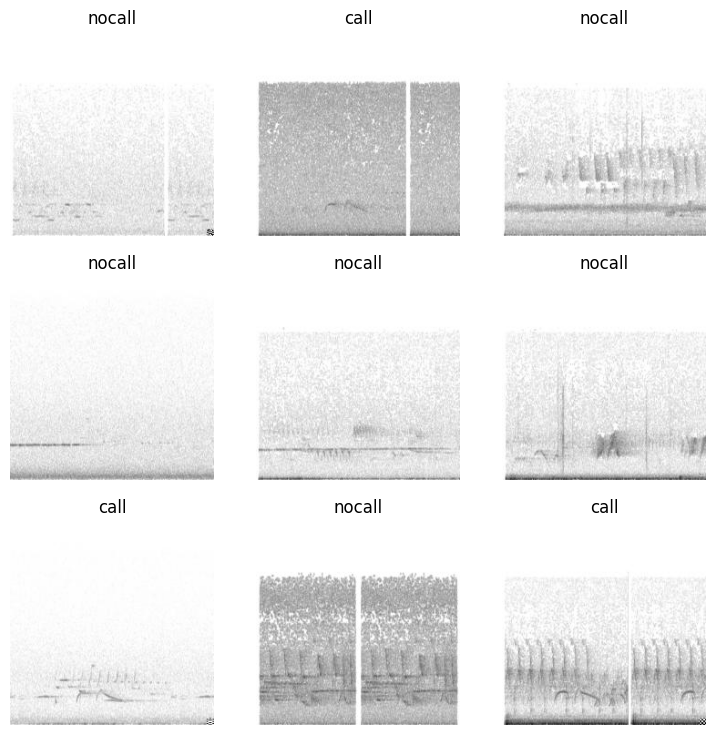

In [22]:
dataloaders.train.show_batch(unique=False)

# Train a model using transfer learning
The model being retranined is a resnet 18 model trained on the imagenet database. 

In [10]:
learn = vision_learner(dataloaders, resnet18, metrics = error_rate)

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.937311,0.927112,0.335840,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.746723,0.903030,0.283208,00:34
1,0.513972,0.618079,0.228070,00:33


During initial run there was an error: 
TypeError: Exception occured in `ProgressCallback` when calling event `after_batch`:
	unsupported format string passed to TensorBase.__format__
    
- Fix: Updated the virtual environment - this was an issue with a change in the PyTorch package not allowing subclasses in Tensor.format

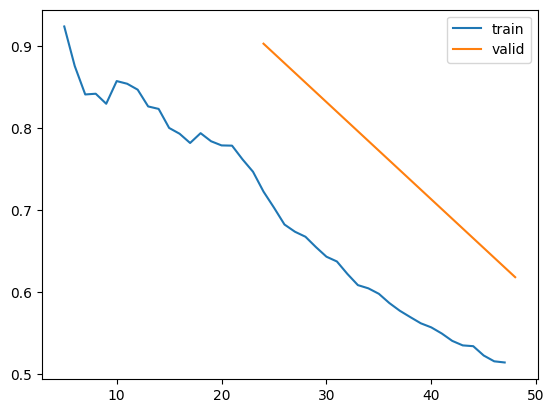

In [21]:
learn.recorder.plot_loss()

Graph interpretation
It's too early to make conclusions from the error rate values at this point due to class inbalance.
- but the curves are showing that the model is training. 
- The blue curve shows the model's performance on items in the training set; the model is learning the specific items in the training set.

- The orange curve shows the model's performance on unseen samples. This is how well the model will generalise to unseen data.  To train a good model, we want to see the  orange curve reducing as the model trains.



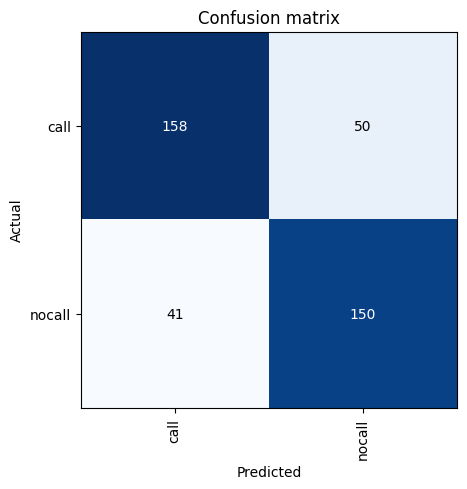

In [23]:
interpreter = ClassificationInterpretation.from_learner(learn)
interpreter.plot_confusion_matrix()

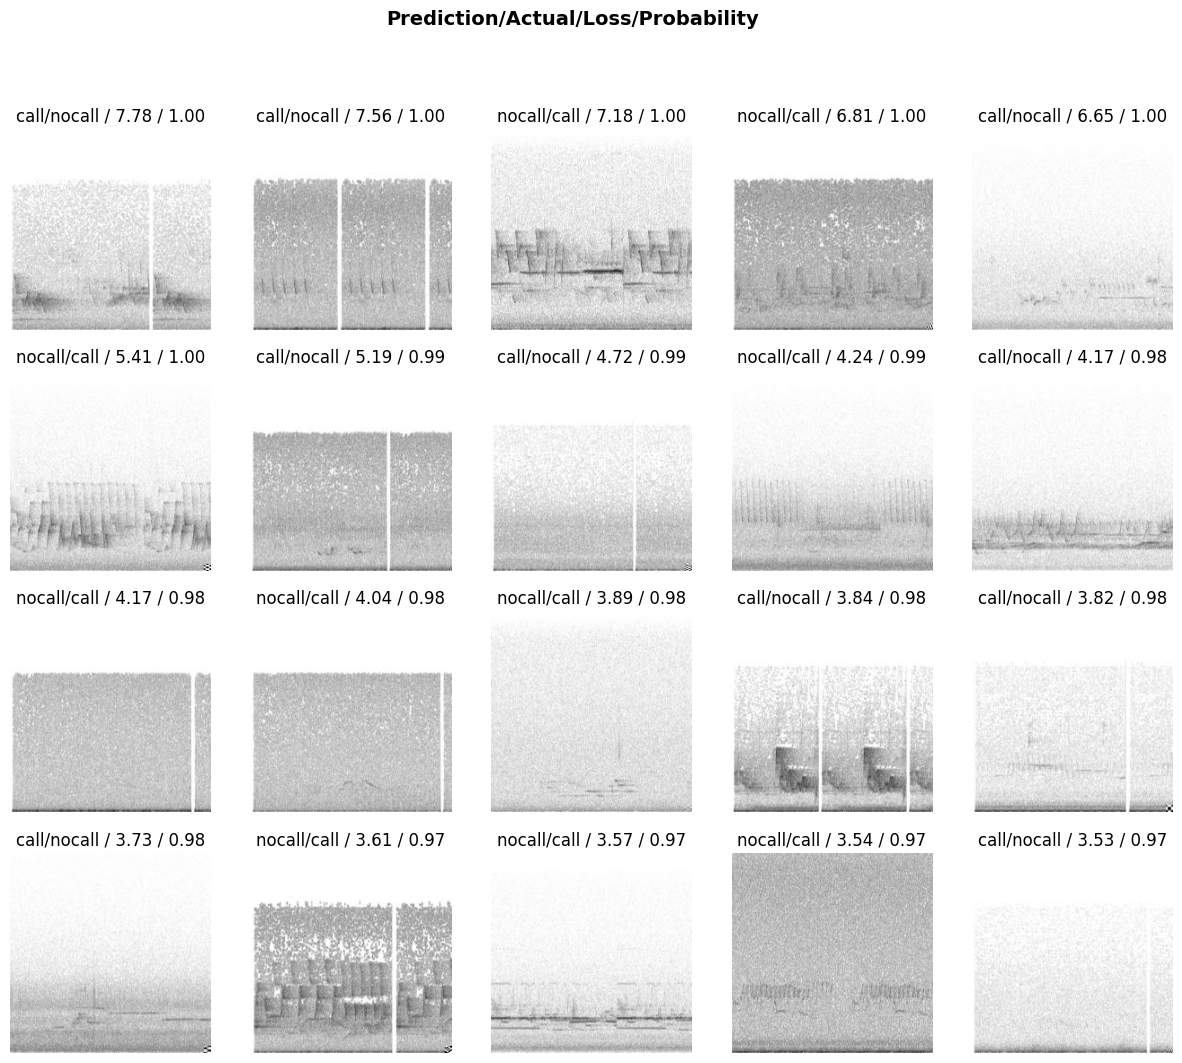

In [24]:
interpreter.plot_top_losses(20)

ValueError: Could not save to JPEG for display

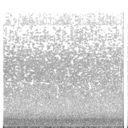

ValueError: Could not save to JPEG for display

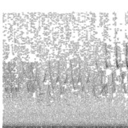

In [25]:
cleaner = ImageClassifierCleaner(learn, max_n=2)

ValueError: Could not save to JPEG for display

For some reasonm the images are getting converted to RGBA format, a format which isn't supported by jpeg.

In [32]:
im = Image.open(filenames[0])

In [33]:
im.mode

'L'

In [36]:
im = im.convert('RGB')

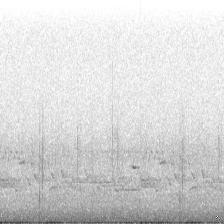

In [37]:
im

'RGB'

In [44]:
def greyscale_to_rgb(im: PIL.Image.Image) -> PIL.Image.Image:
    return im.convert("RGB")

In [48]:
dataloaders = birds.new(_tfms=[greyscale_to_rgb, ToTensor()])

In [49]:
learn = Learner(dataloaders, resnet18, loss_func=error_rate)

In [50]:
learn.fit_one_cycle(4)

AttributeError: 'function' object has no attribute 'parameters'

In [ ]:
cleaner = ImageClassifierCleaner(learn, max_n=2)

In [ ]:
ToTensor

In [ ]:
birds = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2),
    get_y = parent_label,
    item_tfms = [rgba_to_rgb, ToTensor])  # Add the conversion transform here

In [ ]:
dataloaders = birds.dataloaders(path)

In [ ]:
rgba_to_rgb(Image.open(filenames[0])).